```
This notebook runs small ensembles in the Oslo fjord where we perturb a
single parameter for each ensemble to look at the resulting variance 
and how it affects a drift trajectory.

Copyright (C) 2023 SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 9e2194949a236a78754252e0e34f69f9b1e1823f on branch reduced_gravity


In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display
import xarray as xr


#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16
import animation_utils

from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [4]:
%cuda_context_handler gpu_ctx

### Read input file and typical parameters

In [5]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"
nc = Dataset(source_url)
ds = xr.open_dataset(source_url)

# Grid and discretization
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5


### CHOOSE BETWEEN START TIMES

In [30]:
t_start = 285 # 5*24  # 285
t_stop =  t_start + 6
T = (t_stop-t_start)*3600 
timestep_indices = [list(np.arange(t_start, t_stop+1))]


### Generating wind

In [31]:
from gpuocean.utils import WindStress

def generate_wind_field(wind_angle_deg, t_start_index, T):
    """Generating WindStress object with spatially constant, hourly varying wind 
    according to the standard shape in Oslofjord (see Oslofjord-ArtificialParameters.ipynb)
    
    wind_angle_deg - angle of wind field towards north in degree!
    t_start_index  - index for the time when generated wind field is supposed to start
    T              - time span for which the wind field is generated in seconds
    """

    wind_angle = np.deg2rad(wind_angle_deg)

    # Reference wind speed for 0 - 24h 
    wind_u_ref = np.zeros(24)
    wind_u_ref[:10] = -0.5*(np.sin(2*np.pi*(np.arange(0,10)-2.5)/10)+1)
    wind_u_ref[10:] = 5*(np.sin(2*np.pi*(np.arange(10,24)+0.5)/14)+1)

    # Wind fields for 0 - 24h
    wind_u = list(np.cos(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))
    wind_v = list(np.sin(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32))

    # Shifting that reference hours align with t_0
    shift = datetime.datetime.utcfromtimestamp(nc["ocean_time"][t_start_index]).hour
    for shift_hour in range(shift):
        wind_u.append(wind_u.pop(0))
        wind_v.append(wind_v.pop(0))

    # Repeat for several days if necessary
    wind_u = wind_u * int(np.ceil((T/3600+1)/24))
    wind_v = wind_v * int(np.ceil((T/3600+1)/24))

    # Cut relevant time span
    wind_u = wind_u[0:int(T/3600+1)]
    wind_v = wind_v[0:int(T/3600 +1)]

    # Construct time array in simulator time (starting with 0)
    ts = np.arange(T+1, step=3600)

    # Init WindStress object
    wind = WindStress.WindStress(t=ts, wind_u=wind_v, wind_v=wind_u)
    wind.compute_wind_stress_from_wind()

    return wind 

# Reference values

In [32]:
ref_wind_direction = 45.0
ref_wind = generate_wind_field(ref_wind_direction, t_start, T)
print(ref_wind.wind_u)
print(ref_wind.wind_v)
ref_wind_stress_factor = 0.3
ref_windage = 0.01

[array([[0.]], dtype=float32), array([[0.35012794]], dtype=float32), array([[1.3311645]], dtype=float32), array([[2.7488036]], dtype=float32), array([[4.322264]], dtype=float32), array([[5.739903]], dtype=float32), array([[6.72094]], dtype=float32)]
[array([[0.]], dtype=float32), array([[0.35012794]], dtype=float32), array([[1.3311645]], dtype=float32), array([[2.7488036]], dtype=float32), array([[4.322264]], dtype=float32), array([[5.739903]], dtype=float32), array([[6.72094]], dtype=float32)]


In [33]:
# Baroclinic initial conditions
ref_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)
barotropic_ref_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [34]:
# Wind
wind_directions = np.arange(0, 95, 5)
wind_direction_samples = [None]*len(wind_directions)

for i in range(len(wind_directions)):
    wind_direction_samples[i] = generate_wind_field(wind_directions[i], t_start, T)

wind_stress_samples = np.arange(0.0, 0.5, 0.05)
windage_samples = np.arange(0.0, 0.0525, 0.0025)

print(len(wind_direction_samples), len(wind_stress_samples), len(windage_samples))

19 10 21


### Boundary Conditions Reference

Text(0.5, 0.98, 'Boundary conditions')

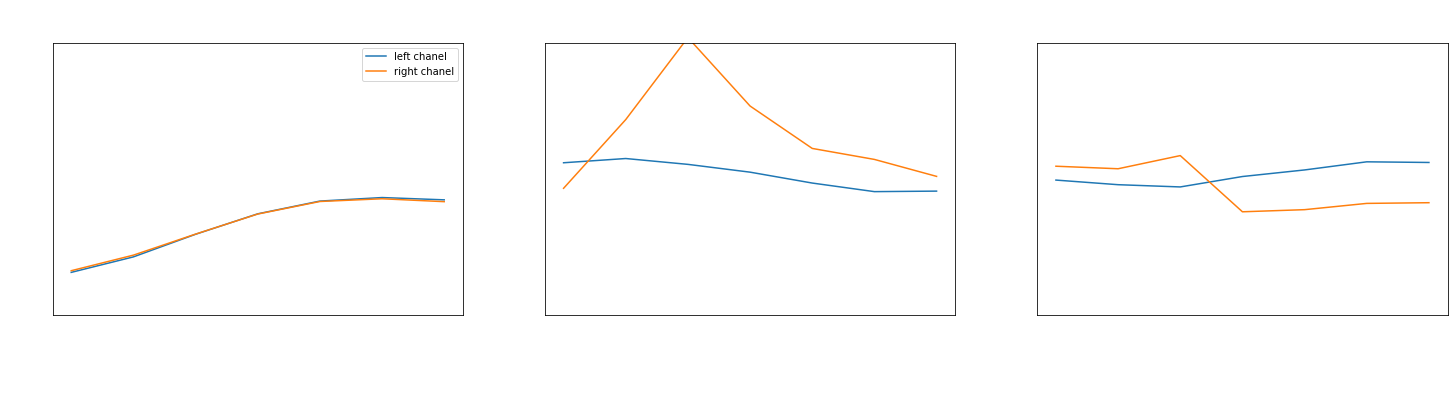

In [35]:
timeaxis = [datetime.datetime.strftime(datetime.datetime.utcfromtimestamp(d), "%Y-%m-%d %H:00") for d in Dataset(source_url)["ocean_time"][t_start:t_stop+1]]

x_left_chanel = 140
x_right_chanel = 190

fig, axs = plt.subplots(1,3, figsize=(25,5))
axs[0].plot(timeaxis, ref_barotropic_data_args["boundary_conditions_data"].south.h[:, x_left_chanel], label="left chanel")
axs[0].plot(timeaxis, ref_barotropic_data_args["boundary_conditions_data"].south.h[:, x_right_chanel], label="right chanel")
axs[0].legend(labelcolor="black")
axs[0].set_ylim([-0.75,0.75])
axs[0].set_title("eta")
axs[0].set_ylabel("m")

axs[0].set_xticks(timeaxis)
axs[0].set_xticklabels(timeaxis,rotation=90)

axs[1].plot(timeaxis, ref_barotropic_data_args["boundary_conditions_data"].south.hv[:, x_left_chanel]/Dataset(source_url)["h"][y0, x0:x1][x_left_chanel], label="left")
axs[1].plot(timeaxis, ref_barotropic_data_args["boundary_conditions_data"].south.hv[:, x_right_chanel]/Dataset(source_url)["h"][y0, x0:x1][x_right_chanel], label="right")
axs[1].set_ylim([-0.5,0.5])
axs[1].set_title("u")
axs[1].set_ylabel("m/s")

axs[1].set_xticks(timeaxis)
axs[1].set_xticklabels(timeaxis,rotation=90)

axs[2].plot(timeaxis, ref_barotropic_data_args["boundary_conditions_data"].south.hu[:, x_left_chanel]/Dataset(source_url)["h"][y0, x0:x1][x_left_chanel], label="left")
axs[2].plot(timeaxis, ref_barotropic_data_args["boundary_conditions_data"].south.hu[:, x_right_chanel]/Dataset(source_url)["h"][y0, x0:x1][x_right_chanel], label="right")
axs[2].set_ylim([-0.5,0.5])
axs[2].set_title("v")
axs[2].set_ylabel("m/s")

axs[2].set_xticks(timeaxis)
axs[2].set_xticklabels(timeaxis,rotation=90)

fig.suptitle("Boundary conditions")

Text(0.5, 0.98, 'Boundary conditions')

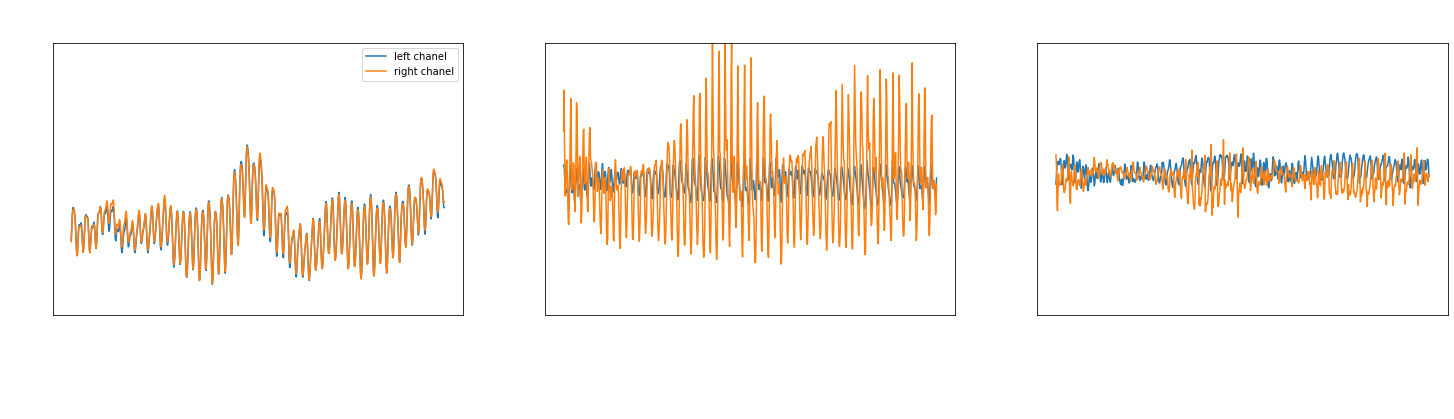

In [13]:
long_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, norkyst_data=False, download_data=False)

timezoom0 = 0
timezoom1 = None

timeaxis = [datetime.datetime.strftime(datetime.datetime.utcfromtimestamp(d), "%Y-%m-%d %H:00") for d in Dataset(source_url)["ocean_time"][timezoom0:timezoom1]]

x_left_chanel = 140
x_right_chanel = 190

fig, axs = plt.subplots(1,3, figsize=(25,5))
axs[0].plot(timeaxis, long_data_args["boundary_conditions_data"].south.h[timezoom0:timezoom1, x_left_chanel], label="left chanel")
axs[0].plot(timeaxis, long_data_args["boundary_conditions_data"].south.h[timezoom0:timezoom1, x_right_chanel], label="right chanel")
axs[0].legend(labelcolor="black")
axs[0].set_ylim([-0.75,0.75])
axs[0].set_title("eta")
axs[0].set_ylabel("m")

axs[0].set_xticks(timeaxis[::48])
axs[0].set_xticklabels(timeaxis[::48],rotation=90)

axs[1].plot(timeaxis, long_data_args["boundary_conditions_data"].south.hv[timezoom0:timezoom1, x_left_chanel]/Dataset(source_url)["h"][y0, x0:x1][x_left_chanel], label="left")
axs[1].plot(timeaxis, long_data_args["boundary_conditions_data"].south.hv[timezoom0:timezoom1, x_right_chanel]/Dataset(source_url)["h"][y0, x0:x1][x_right_chanel], label="right")
axs[1].set_ylim([-0.5,0.5])
axs[1].set_title("u")
axs[1].set_ylabel("m/s")

axs[1].set_xticks(timeaxis[::24])
axs[1].set_xticklabels(timeaxis[::24],rotation=90)

axs[2].plot(timeaxis, long_data_args["boundary_conditions_data"].south.hu[timezoom0:timezoom1, x_left_chanel]/Dataset(source_url)["h"][y0, x0:x1][x_left_chanel], label="left")
axs[2].plot(timeaxis, long_data_args["boundary_conditions_data"].south.hu[timezoom0:timezoom1, x_right_chanel]/Dataset(source_url)["h"][y0, x0:x1][x_right_chanel], label="right")
axs[2].set_ylim([-0.5,0.5])
axs[2].set_title("v")
axs[2].set_ylabel("m/s")

axs[2].set_xticks(timeaxis[::48])
axs[2].set_xticklabels(timeaxis[::48],rotation=90)

fig.suptitle("Boundary conditions")

### Initial Conditions Reference

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
  if sys.path[0] == "":


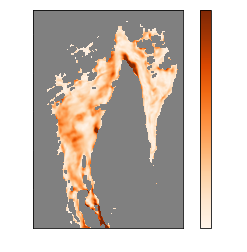

In [14]:
from gpuocean.utils import PlotHelper
_, H_m = barotropic_ref_sim.downloadBathymetry()
eta = ref_barotropic_data_args["eta0"]
hu  = ref_barotropic_data_args["hu0"]
hv  = ref_barotropic_data_args["hv0"]

V = PlotHelper.genVelocity(eta + H_m, hu, hv)
V.mask = eta.mask

# Colormaps
v_cmap=plt.cm.Oranges
v_cmap.set_bad('grey', alpha=1.0)

plt.imshow(V, cmap=v_cmap, vmin=0.0, vmax=0.1)
plt.colorbar()

In [ ]:
# Barotropic data args by starting from earlier timesteps and doing a sufficient spin-up
num_bar_realizations = 5
barotropic_shiftedspinup_data_args = []

for i in range(1,num_bar_realizations+1):

    shiftspinup_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=[np.arange(t_start-i, t_start+1)], norkyst_data=False, land_value=0.0, download_data=False)
    shiftspinup_barotropic_data_args["wind"] = generate_wind_field(ref_wind_direction, 285-i, i*3600)
    shitspinup_barotropic_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(shiftspinup_barotropic_data_args), dt=0.0)
    shitspinup_barotropic_sim.step(i*3600)
    eta, hu, hv = shitspinup_barotropic_sim.download()

    spinnedup_barotropic_data_args = copy.copy(ref_barotropic_data_args)
    spinnedup_barotropic_data_args["eta0"] = eta
    spinnedup_barotropic_data_args["hu0"] = hu
    spinnedup_barotropic_data_args["hv0"] = hv
    barotropic_shiftedspinup_data_args.append(spinnedup_barotropic_data_args)


from gpuocean.utils import PlotHelper
_, H_m = barotropic_ref_sim.downloadBathymetry()

fig, axs = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    eta = barotropic_shiftedspinup_data_args[i]["eta0"]
    hu  = barotropic_shiftedspinup_data_args[i]["hu0"]
    hv  = barotropic_shiftedspinup_data_args[i]["hv0"]

    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = eta.mask

    # Colormaps
    v_cmap=plt.cm.Oranges
    v_cmap.set_bad('grey', alpha=1.0)

    axs[i].imshow(V, cmap=v_cmap, vmin=0.0, vmax=0.1)

In [15]:
# Barotropic data args by starting from earlier timesteps and doing a sufficient spin-up
barotropic_spinup_data_args = []

spinup_t = 24

spinup_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=[np.arange(t_start-spinup_t, t_start+1)], norkyst_data=False, land_value=0.0, download_data=False)
spinup_barotropic_data_args.pop("wind")

for wind_direction in wind_directions[::9]:
    wind = WindStress.WindStress(t=[0], wind_u=[np.array([[np.cos(np.deg2rad(wind_direction))*10]]).astype(np.float32)], wind_v=[np.array([[np.sin(np.deg2rad(wind_direction))*10]]).astype(np.float32)])
    spinup_barotropic_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(spinup_barotropic_data_args), dt=0.0, wind=wind)
    spinup_barotropic_sim.step(spinup_t*3600)
    eta, hu, hv = spinup_barotropic_sim.download()

    spunup_barotropic_data_args = copy.copy(ref_barotropic_data_args)
    spunup_barotropic_data_args["eta0"] = eta
    spunup_barotropic_data_args["hu0"] = hu
    spunup_barotropic_data_args["hv0"] = hv
    barotropic_spinup_data_args.append(spunup_barotropic_data_args)



This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))
  from ipykernel import kernelapp as app


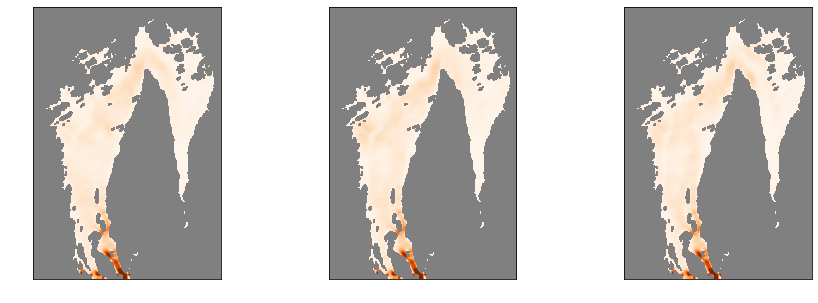

In [16]:
from gpuocean.utils import PlotHelper
_, H_m = barotropic_ref_sim.downloadBathymetry()

fig, axs = plt.subplots(1,len(barotropic_spinup_data_args),figsize=(5*len(barotropic_spinup_data_args),5))
for i in range(len(barotropic_spinup_data_args)):
    eta = barotropic_spinup_data_args[i]["eta0"]
    hu  = barotropic_spinup_data_args[i]["hu0"]
    hv  = barotropic_spinup_data_args[i]["hv0"]

    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = eta.mask

    # Colormaps
    v_cmap=plt.cm.Oranges
    v_cmap.set_bad('grey', alpha=1.0)

    axs[i].imshow(V, cmap=v_cmap, vmin=0.0, vmax=0.1)

In [ ]:
# Barotropic data args by starting from earlier timesteps and doing a sufficient spin-up
barotropic_shifted_data_args = []

for i in range(-1,1+1):
    barotropic_shifted_data_args.append(NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=[np.arange(285+i, 285+i+6)], norkyst_data=False, land_value=0.0, download_data=False))


from gpuocean.utils import PlotHelper
_, H_m = barotropic_ref_sim.downloadBathymetry()

fig, axs = plt.subplots(1,len(barotropic_shifted_data_args),figsize=(25,5))
for i in range(len(barotropic_shifted_data_args)):
    eta = barotropic_shifted_data_args[i]["eta0"]
    hu  = barotropic_shifted_data_args[i]["hu0"]
    hv  = barotropic_shifted_data_args[i]["hv0"]

    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = eta.mask

    # Colormaps
    v_cmap=plt.cm.Oranges
    v_cmap.set_bad('grey', alpha=1.0)

    axs[i].imshow(V, cmap=v_cmap, vmin=0.0, vmax=0.1)

### Bathymetry

In [ ]:

num_bar_realizations = 5
barotropic_bathymetry_data_args = []

Hm = Dataset(source_url)["h"][y0-1:y1+1,x0-1:x1+1]
Hm = np.ma.array(Hm, mask=(Hm==0))

for i in range(num_bar_realizations):

    pert_barotropic_data_args = copy.copy(ref_barotropic_data_args)
    pert_barotropic_data_args["H"] = OceanographicUtilities.midpointsToIntersections(Hm * (1+np.random.uniform(-0.2,0.2, size=Hm.shape)), land_value=0.0, iterations=10)[0]

    barotropic_bathymetry_data_args.append(pert_barotropic_data_args)



fig, axs = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    axs[i].imshow(-barotropic_bathymetry_data_args[i]["H"], cmap="ocean", vmin=-300.0, vmax=0)

# Utility functions to run ensembles and plot variance and trajectories 

In [17]:
def run_sample(data_args_in, g=None, wind=None, wind_stress_factor=None, windage=0.0, friction=None, end_time=T, pert_init_drifter=False):
    data_args = copy.deepcopy(data_args_in)
    if g is not None:
        data_args["g"] = g
    if wind is not None:
        data_args["wind"] = wind
    if wind_stress_factor is not None:
        data_args["wind_stress_factor"] = wind_stress_factor
    if friction is not None:
        data_args["r"] = friction
    
    # Create sim
    sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(data_args),  dt=0.0)

    # Make observation object to log drift trajectory
    observation_type = dautils.ObservationType.UnderlyingFlow 
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                    }
    trajectories = Observation.Observation(**observation_args)

    # Create and initialize drifter objects
    #initx = [ 6000]
    #inity = [12000]
    initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
    inity = [12000, 3000, 7500, 22000, 16000, 15000]
    num_drifters = len(initx)

    if pert_init_drifter:
        initx += np.random.normal(scale=100, size=num_drifters)
        inity += np.random.normal(scale=100, size=num_drifters)

    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                        boundaryConditions = sim.boundary_conditions,
                                                        domain_size_x = trajectories.domain_size_x,
                                                        domain_size_y = trajectories.domain_size_y,
                                                        gpu_stream = sim.gpu_stream,
                                                        wind=data_args["wind"],
                                                        wind_drift_factor = windage
                                                        )

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)

    # Attach drifters and log init position
    sim.attachDrifters(drifters)
    trajectories.add_observation_from_sim(sim)

    # Simulation loop, logging drifter positions every 2 min
    drifter_log_dt = 2*60
    t = 0
    while t < end_time:
        dt = min(drifter_log_dt, end_time - t)
        sim.step(dt)
        t = t + dt
        trajectories.add_observation_from_sim(sim)

    # return final ocean state and trajectory
    eta, hu, hv = sim.download()
    return {"eta": eta, "hu": hu, "hv": hv, "trajectories": trajectories}


In [18]:

def _get_statistics(results, ref_sim):
    N = len(results)
    etas = np.zeros((N, results[0]["eta"].shape[0], results[0]["eta"].shape[1]))
    hus  = np.zeros((N, results[0]["hu"].shape[0],  results[0]["hu"].shape[1]))
    hvs  = np.zeros((N, results[0]["hv"].shape[0],  results[0]["hv"].shape[1]))
    for i in range(N):
        etas[i,:,:] = results[i]["eta"]
        hus[i,:,:] = results[i]["hu"]
        hvs[i,:,:] = results[i]["hv"]

    _, Hm = ref_sim.downloadBathymetry()


    v = np.sqrt((hus/(etas + Hm))**2 + (hvs/(etas + Hm))**2)

    mean_eta = np.ma.MaskedArray(np.mean(etas, axis=0), mask=results[0]["eta"].mask)
    mean_v   = np.ma.MaskedArray(np.mean(v,    axis=0), mask=results[0]["eta"].mask)
    var_eta  = np.ma.MaskedArray(np.var(etas,  axis=0), mask=results[0]["eta"].mask)
    var_v    = np.ma.MaskedArray(np.var(v,     axis=0), mask=results[0]["eta"].mask)


    return mean_eta, mean_v, var_eta, var_v


zoom0 = [100, 150, 200, 275]
zoom1 = [125, 175,  25, 100]
zoom2 = [ 75, 125, 125, 200]
zoom3 = [ 50, 100, 275, 350]

def _plot_field(results, field, ref_sim, T, title, plot_trajectories=True, 
                cmap=plt.cm.Reds, vmin=0.0, vmax=0.5, filename=None, zoom=[0,None,0,None]):
    
    with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.tick_params(axis='both', which='major', labelsize=15)

        zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

        if zoom_x1 is None:
            dom_x1 = ref_sim.nx
        else:
            dom_x1 = zoom_x1
        if zoom_y1 is None:
            dom_y1 = ref_sim.ny
        else:
            dom_y1 = zoom_y1
        domain_extent = [zoom_x0*ref_sim.dx/1000, dom_x1*ref_sim.dx/1000, zoom_y0*ref_sim.dy/1000, dom_y1*ref_sim.dy/1000]

        cmap_cp = copy.copy(cmap)
        cmap_cp.set_bad("grey", alpha = 1.0)

        im = ax.imshow(field[zoom_y0:zoom_y1, zoom_x0:zoom_x1], interpolation="none", origin='lower', 
                       cmap=cmap_cp, 
                       vmin=vmin, vmax=vmax, 
                       extent=domain_extent)
        if plot_trajectories:
            num_drifters = results[0]["trajectories"].get_num_drifters()
            for d in range(num_drifters):
                for i in range(len(results)):
                    drifter_path = results[i]["trajectories"].get_drifter_path(d, 0, T, in_km = True)[0]
                    start_pos = drifter_path[0,:]

                    if (domain_extent[0] < start_pos[0] < domain_extent[1]) and (domain_extent[2] < start_pos[1] < domain_extent[3]):
                        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                                        0.01, color = 'blue',
                                                                        fill=True, zorder=10)
                        ax.add_patch(circ_start)

                        ax.plot(drifter_path[:,0], drifter_path[:,1], color="cornflowerblue", ls="-", zorder=5)
                        end_pos = drifter_path[-1,:]
                        ax.plot(end_pos[0], end_pos[1], 'x', color='darkblue', zorder=11)
    
        cb = plt.colorbar(im, ax=ax) #, shrink=0.8)
        cb.ax.tick_params(labelsize=15)

        plt.title(title+"\n", fontsize=16)
        plt.tight_layout()

        if filename is not None:
            folder = "sensitivity_figs"
            os.makedirs(folder, exist_ok=True)
            plt.savefig(os.path.join(folder, filename+".pdf"))


def plot_drifters_and_variance(results, ref_sim, T, suptitle, filename=None, vmax=None, zoom=[0,None,0,None]):
    # results are list with dicts [{eta, hu, hv, trajectories}]

    mean_eta, mean_vel, var_eta, var_vel = _get_statistics(results, ref_sim)

    if vmax is None:
        vmax = max(var_vel.max()/4, 1e-6)

    _plot_field(results, var_vel, ref_sim, T, suptitle, vmin=0, vmax=vmax, filename=filename, zoom=zoom)
    #_plot_field(results, var_eta, ref_sim, T, "MLD variance", vmin=0, vmax=4)
    
    print("Maximum velocity: ", mean_vel.max(), var_vel.max())

#plot_drifters_and_variance(mld_dens_results, ref_sim, T, "Perturbing MLD init")

# Plot initial positions of the drifters with annotations

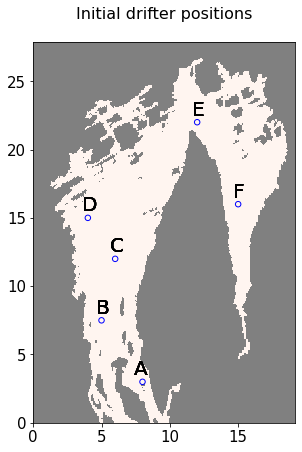

In [19]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax.tick_params(axis='both', which='major', labelsize=15)

    domain_extent = [0, barotropic_ref_sim.nx*barotropic_ref_sim.dx/1000, 0, barotropic_ref_sim.ny*barotropic_ref_sim.dy/1000]

    cmap_cp = copy.copy(plt.cm.Reds)
    cmap_cp.set_bad("grey", alpha = 1.0)
    background_field = np.zeros_like(ref_barotropic_data_args["eta0"])

    im = ax.imshow(background_field, interpolation="none", origin='lower', 
                cmap=cmap_cp, 
                extent=domain_extent)

    for d in range(len(initx)):
        circ_start = matplotlib.patches.Circle((initx[d]/1000, inity[d]/1000), 
                                                0.2, color = 'blue',
                                                fill=False, zorder=10)
        ax.add_patch(circ_start)

        # plt.annotate("hei",(initx[0]-1, inity[0]+1))
        annotation_fontsize = 20
        ax.annotate("C",[initx[0]/1000-0.4, inity[0]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("A",[initx[1]/1000-0.6, inity[1]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("B",[initx[2]/1000-0.4, inity[2]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("E",[initx[3]/1000-0.4, inity[3]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("F",[initx[4]/1000-0.4, inity[4]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("D",[initx[5]/1000-0.4, inity[5]/1000+0.5], fontsize=annotation_fontsize )


    plt.title("Initial drifter positions\n", fontsize=16)
    #plt.tight_layout()


# Run experiments and plot results

Barotropic reference

In [20]:
ref_barotropic_result = [run_sample(ref_barotropic_data_args)]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


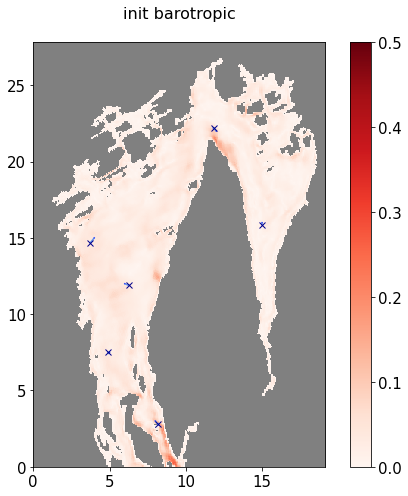

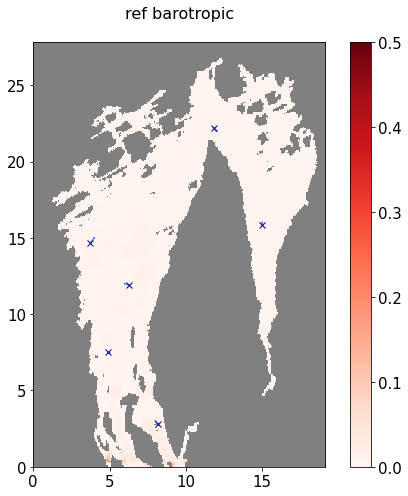

In [21]:
initV = np.ma.sqrt((ref_barotropic_data_args["hu0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_data_args["hv0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)
refV = np.ma.sqrt((ref_barotropic_result[0]["hu"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_result[0]["hv"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)
_plot_field(ref_barotropic_result, initV, barotropic_ref_sim, T, "init barotropic", plot_trajectories=True)
_plot_field(ref_barotropic_result, refV, barotropic_ref_sim, T, "ref barotropic", plot_trajectories=True)

Init drifter position

In [22]:
barotropic_drifterinit_no_windage = []
for i in range(len(wind_direction_samples[::2])):
    barotropic_drifterinit_no_windage.append( run_sample(ref_barotropic_data_args, wind=wind_direction_samples[2*i], wind_stress_factor=ref_wind_stress_factor, windage=0, pert_init_drifter=True) )


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.17505218118348576 2.381084459060799e-06


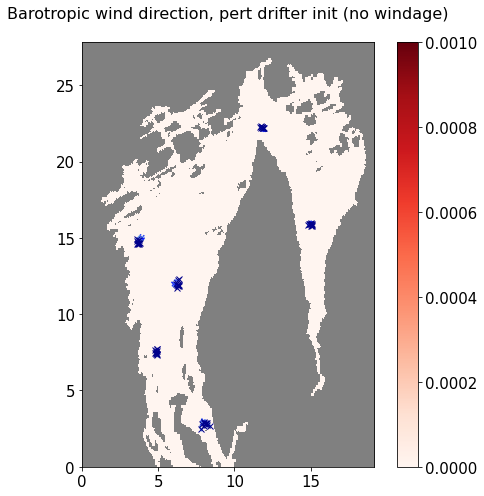

In [23]:

plot_drifters_and_variance(barotropic_drifterinit_no_windage, barotropic_ref_sim, T, "Barotropic wind direction, pert drifter init (no windage)", vmax=0.001)

Barotropic wind direction

In [ ]:
# barotropic_wind_direction_results = []
barotropic_wind_direction_results_no_windage = []
for i in range(len(wind_direction_samples[::2])):
    # barotropic_wind_direction_results.append( run_sample(ref_barotropic_data_args, wind=wind_direction_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=ref_windage) )
    barotropic_wind_direction_results_no_windage.append( run_sample(ref_barotropic_data_args, wind=wind_direction_samples[2*i], wind_stress_factor=ref_wind_stress_factor, windage=0) )


In [ ]:

# plot_drifters_and_variance(barotropic_wind_direction_results, barotropic_ref_sim, T, "Barotropic wind direction")
plot_drifters_and_variance(barotropic_wind_direction_results_no_windage, barotropic_ref_sim, T, "Barotropic wind direction (no windage)")

Barotropic spin-ups

In [25]:
barotropic_spinup_results_no_windage = []
for i in range(len(wind_direction_samples[::9])):
    barotropic_spinup_results_no_windage.append( run_sample(barotropic_spinup_data_args[i], wind=wind_direction_samples[9*i], wind_stress_factor=ref_wind_stress_factor, windage=0) )


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Maximum velocity:  0.17448999013936006 3.5001923922840583e-06


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


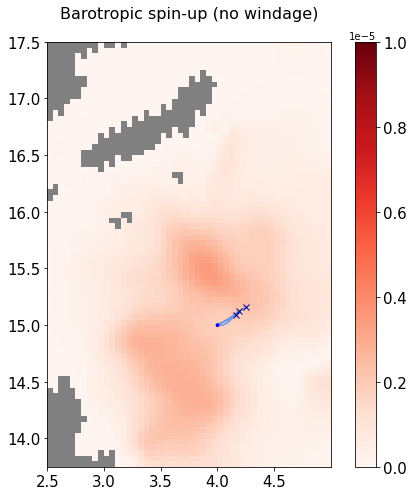

In [29]:

plot_drifters_and_variance(barotropic_spinup_results_no_windage, barotropic_ref_sim, T, "Barotropic spin-up (no windage)", vmax=1e-5, zoom=zoom3)

Time shifting

In [ ]:
barotropic_shift_results_no_windage = []
for i in range(len(barotropic_shifted_data_args)):
    barotropic_shift_results_no_windage.append( run_sample(barotropic_shifted_data_args[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=0) )

plot_drifters_and_variance(barotropic_shift_results_no_windage, barotropic_ref_sim, T, "Barotropic shiftiung (no windage)", vmax=0.00005)

Barotropic bathymetry

In [ ]:
barotropic_bathymetry_results_no_windage = []
for i in range(len(barotropic_bathymetry_data_args)):
        barotropic_bathymetry_results_no_windage.append( run_sample(barotropic_bathymetry_data_args[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=0) )

# plot_drifters_and_variance(barotropic_bathymetry_results, barotropic_ref_sim, T, "Barotropic bathymetry", filename="barotropic_bathymetry")
plot_drifters_and_variance(barotropic_bathymetry_results_no_windage, barotropic_ref_sim, T, "Barotropic bathymetry (no windage)")

Small Scale Perturbations

In [ ]:
small_scale_results_no_wind = []

small_scale_barotropic_data_args = copy.copy(ref_barotropic_data_args)
small_scale_barotropic_data_args["small_scale_perturbation"] = True
small_scale_barotropic_data_args["small_scale_perturbation_amplitude"] = 0.000001
small_scale_barotropic_data_args["small_scale_perturbation_interpolation_factor"] = 21

for i in range(5):
    small_scale_results_no_wind.append( run_sample(small_scale_barotropic_data_args))

plot_drifters_and_variance(small_scale_results_no_wind, barotropic_ref_sim, T, "Barotropic small scale perts (no windage)")